In [151]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [152]:
def f(x):
    return 3*x**2 - 4*x + 5

In [153]:
f(3.0)

20.0

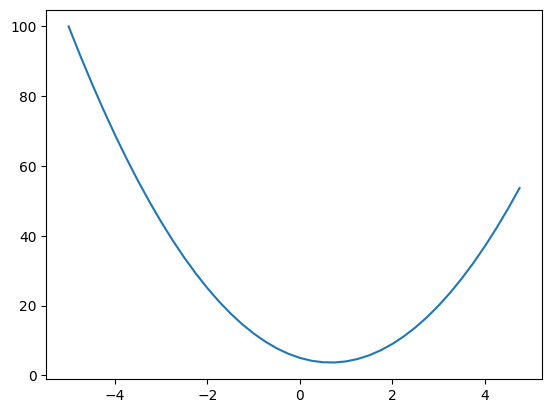

In [154]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [155]:
h = 0.00000000001
x = 2.3
(f(x+h) - f(x))/h

9.799805411603302

In [156]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [157]:
h = 0.00001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 4.0
d2 3.9999699999999994
slope -3.000000000064062


In [255]:
class Value:
    def __init__(self,data, _children = (), _op="", _label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._label = _label
        self._backward = lambda:None
        self.grad = 0.0
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other),'+')
        
        def _backward():
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
        out._backward = _backward 
            
        return out
    
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other),'*')
        
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward 
        
        return out
    
    def __pow__(self,other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data ** other.data, (self,other),'**')
        
        def _backward():
            self.grad += other.data * (self.data ** (other.data - 1)) * out.grad
        out._backward = _backward
        
        return out
            
    def __rmul__(self,other):
        return self * other
    
    def __truediv__(self,other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self,other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,),'tanh')
        
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward 
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,),'exp')
        
        def _backward():
            self.grad = out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [250]:
a = Value(2.0)
b = Value(4.0)
a-b

Value(data=-2.0)

In [258]:
x1 = Value(2.0, _label='x1')
x2 = Value(0.0, _label='x2')
w1 = Value(-3.0, _label='w1')
w2 = Value(1.0, _label='w2')

b = Value(6.8813735870195432, _label='b')

x1w1 = x1 * w1; x1w1._label = 'x1w1'
x2w2 = x2 * w2; x2w2._label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n._label = 'n'

e = (2*n).exp()
o = (e - 1)/(e + 1); o._label = 'o'

o.backward()

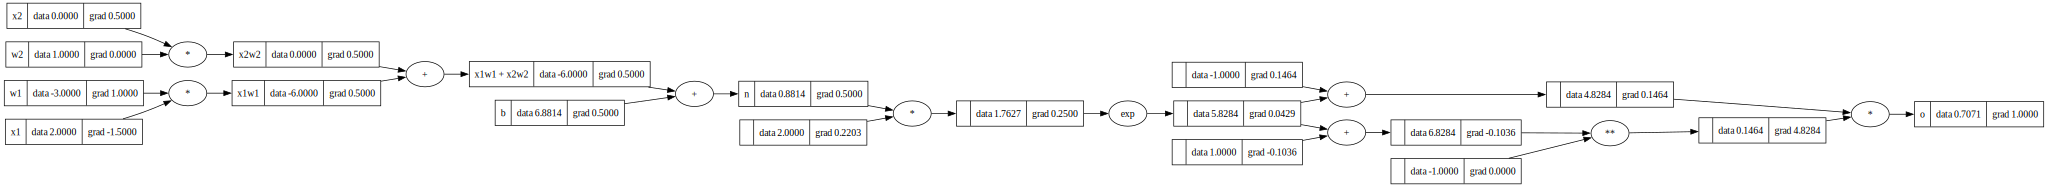

In [259]:
draw_dot(o)